## Classification Implementation (Predicting Customer Churn)

✅ One-hot encoding is applied to UniqueCountries & LastPurchaseYM (YearMonth).

✅ Numeric features (TotalSpend, OrderCount, AvgOrderValue) are standardized for better scaling.

✅ No manual pruning needed in Random Forest (ensemble handles complexity)

### Step 1: Prepare Data for Classification

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
df = pd.read_excel(url, sheet_name="Online Retail")

In [9]:
# Data Cleaning
df = df.dropna(subset=["CustomerID"])
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
df = df[df["Quantity"] > 0]
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["YearMonth"] = df["InvoiceDate"].dt.year * 100 + df["InvoiceDate"].dt.month  # YYYYMM format

In [10]:
# Aggregate Customer-Level Data for Classification
customer_data = df.groupby("CustomerID").agg(
    TotalSpend=("TotalPrice", "sum"),
    OrderCount=("InvoiceNo", "nunique"),
    AvgOrderValue=("TotalPrice", "mean"),
    UniqueCountries=("Country", "nunique"),
    LastPurchase=("InvoiceDate", "max"),
    LastPurchaseYM=("YearMonth", "max")  # Most recent purchase Year-Month
).reset_index()

# Define Churn: No purchase in the last 6 months
latest_date = df["InvoiceDate"].max()
customer_data["Churn"] = (latest_date - customer_data["LastPurchase"]).dt.days > 180
customer_data["Churn"] = customer_data["Churn"].astype(int)
customer_data = customer_data.drop(columns=["LastPurchase"])

In [11]:
# One-Hot Encode `UniqueCountries` and `LastPurchaseYM`
customer_data = pd.get_dummies(customer_data, columns=["UniqueCountries", "LastPurchaseYM"], prefix=["CountryCount", "YM"])

In [13]:
# Define Features & Target
X_clf = customer_data.drop(columns=["CustomerID", "Churn"])
y_clf = customer_data["Churn"]

# Standardize Numeric Features
numeric_features = ["TotalSpend", "OrderCount", "AvgOrderValue"]
scaler = StandardScaler()
X_clf[numeric_features] = scaler.fit_transform(X_clf[numeric_features])


### Step 2: Train Random Forest Classifier

In [15]:
# Train-Test Split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

# Train Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_clf, y_train_clf)

# Predict & Evaluate
y_pred_clf = rf_clf.predict(X_test_clf)
accuracy = accuracy_score(y_test_clf, y_pred_clf)

print(f"Random Forest Classification Accuracy: {accuracy:.2%}")
print("Classification Report:\n", classification_report(y_test_clf, y_pred_clf))

Random Forest Classification Accuracy: 97.81%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       703
           1       0.95      0.94      0.94       165

    accuracy                           0.98       868
   macro avg       0.97      0.96      0.96       868
weighted avg       0.98      0.98      0.98       868



### Step 3: Feature Importance (Classification)

C:\Users\serko\AppData\Local\Temp\ipykernel_7704\1985088207.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_clf, palette="Greens_r")


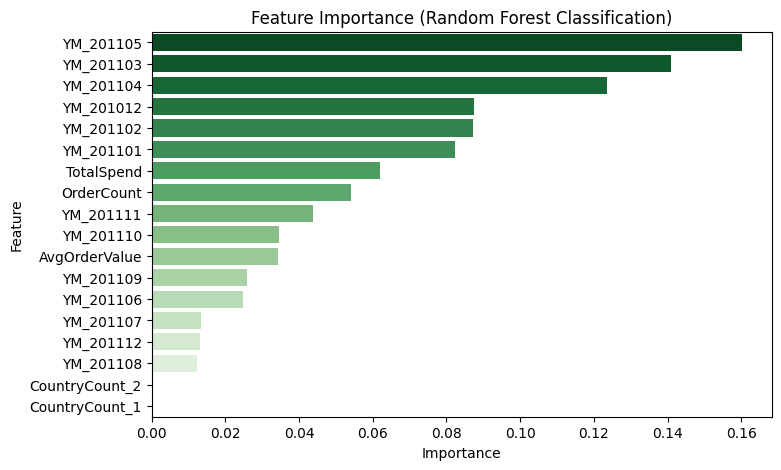

In [16]:
# Feature Importance Analysis
feature_importance_clf = pd.DataFrame({
    "Feature": X_clf.columns,
    "Importance": rf_clf.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plot Feature Importance
plt.figure(figsize=(8, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importance_clf, palette="Greens_r")
plt.title("Feature Importance (Random Forest Classification)")
plt.show()

Notes for Decision Tree Analysis & Pruning

🔹 Do We Need Decision Tree Pruning in Random Forest?

- Random Forest automatically reduces overfitting because it uses multiple trees with random splits.

- Pruning individual trees isn't necessary because the ensemble effect minimizes over-complexity.

- However, we can control complexity by:
    * Limiting max depth (max_depth)
    * Reducing min samples per split (min_samples_split)
    * Controlling number of trees (n_estimators)

🔹 Should We Manually Prune?

- Not necessary in Random Forest (pruning is more relevant in single decision trees).

- Instead, tuning hyperparameters (e.g., max_depth, n_estimators) is better for performance.